# Содержание
1. [Обзор данных](#1)
2. [Предобработка и исследовательский анализ данных](#2) 
3. [Формулировка ML-задачи на основе бизнес-задачи](#3)
4. [Разработка модели ML](#4)
5. [Портрет «ненадёжного» клиента](#5)
6. [Общий вывод](#6)

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Заказчик исследования** — сеть отелей «Как в гостях». 

**Цель исследования** - разработать систему, которая предсказывает отказ от брони.

Если модель покажет, что бронь будет отменена, клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Задачи:**

- подготовить данные;
- построить две модели линейной регрессии на разных наборах данных:
  - используя все данные из файла,
  - используя только числовые переменные, исключив категориальные;
- сравнить результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2.


## Обзор Данных <a id="1"></a>

### Подключение необходимых библиотек.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve

In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

### Открытие и изучение данных.

In [3]:
server_path = '/datasets/'
local_path = ''
train = 'hotel_train.csv'
test = 'hotel_test.csv'

try:
    data_train = pd.read_csv(server_path + train)  
    data_test = pd.read_csv(server_path + test)
except: 
    data_train = pd.read_csv(local_path + train)  
    data_test = pd.read_csv(local_path + test)

In [4]:
data_train.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [5]:
data_test.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Пропусков не выявлено. Проверим данные на наличие дубликатов.

In [8]:
def unique_check(data):
    columns = data.columns
    for c in columns:
        print(c.upper(), '\n', data[c].unique(), '\n')

In [9]:
unique_check(data_train)

ID 
 [    0     1     2 ... 84094 84117 84121] 

IS_CANCELED 
 [0 1] 

LEAD_TIME 
 [  7.  14.   0.   9.  85.  75.  23.  18.  68.  37.  72.  48.  77.  99.
  40.  15.  36.  70.  45.  16. 107.  47.  96. 113.  50.   3.   1.  10.
   5.  17.  93.  71.  63.  62. 101.   2.  81.  12. 109. 102.   4.  92.
  95.  86.  78.  29.  30.  51.  33.   8. 100.  80.  97.  64.  90.  27.
  82.  94. 115. 111.  98.  66. 104.  65.  55.  21.  88.  43.  54. 280.
  24. 103. 249.  13.  79.  35.  31.  34.  44. 304. 117.  84. 110.  59.
 116.  91.  42.  60. 321.  32.  56.  41.  76.  49.  73. 112.  39.  58.
  57.  19.  53.  38.   6. 108.  26. 123.  28. 118.  46.  69.  52.  89.
  61.  22.  67. 105.  25.  11.  87. 299.  74. 298. 119.  20.  83. 136.
 129. 124. 130. 131. 139. 122. 106. 137. 120. 135. 150. 143. 151. 126.
 147. 128. 156. 132. 164. 159. 161. 333. 149. 154. 297. 163. 314. 323.
 340. 142. 302. 175. 166. 114. 140. 157. 310. 172. 145. 121. 127. 178.
 152. 158. 125. 185. 177. 165. 200. 192. 174. 134. 350. 283. 160.

In [10]:
unique_check(data_test)

ID 
 [ 6086  6087  6088 ... 97901 97902 97903] 

IS_CANCELED 
 [1 0] 

LEAD_TIME 
 [ 74.  62.  71. 172.  52. 143.  21.  89.  48.  31.  20. 173.  23.  46.
 149.  44.  68.   6.  43. 112.  59.  93.   4. 115. 187.  11.   2.  15.
  66. 113. 125. 161. 154.   1.   0.  35.  37.  60. 129.  78.  10.  82.
   8.  22.  33. 108.  87. 106.  45.  40.  17.   5.  16.   3.  41. 135.
 123. 128.  47.  12. 124. 160.  58.  65. 281.  24.  30.  27.   9.  94.
 219.  84.  79.  72.  36. 292. 186.  85. 169. 166.  28.  83. 111.  54.
 200.  80. 102.  95. 170. 307. 298.  55.  77.  32.  25. 238.   7.  19.
 211. 137.  39.  18. 206.  42. 179. 205. 142.  38.  92.  56.  29. 119.
  73. 320.  34. 127.  69.  13. 140.  14. 164.  51.  70. 120.  76. 105.
  50. 191.  26.  75. 116. 184.  53.  49.  63. 194. 167. 312. 171. 218.
  86. 100. 146.  64. 148.  81.  88.  57. 339. 332. 133. 208.  61. 177.
 157. 278. 285. 210. 232. 139. 134. 204. 201. 216. 340. 350. 214. 226.
 273. 103. 136. 176. 180. 192. 175. 145. 162. 174. 117. 255. 364.

In [11]:
data_train.duplicated().sum()

0

In [12]:
data_test.duplicated().sum()

0

Дубликатов не обнаружено.

Целевой признак для модели - столбец is_canceled. Проверим баланс классов для обучения.

In [13]:
data_train['is_canceled'].value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

## Вывод по шагу 1.

В некоторых столбцах (lead_time, adults, children, babies) следует заменить тип данных с float на int для удобства дальнейшего исследования. В значениях столбцов reserved_room_type и meal нужно убрать пробелы. Пропусков и дубликатов в данных нет. Перед обучением модели классы следует сбалансировать. В следующем шаге проведем исследовательский анализ.

## Предобработка и исследовательский анализ данных <a id="2"></a>

Заменим типы данных.

In [14]:
columns = ['lead_time', 'adults', 'children', 'babies']
for c in columns:
    data_train[c] = data_train[c].astype('int64')
    data_test[c] = data_test[c].astype('int64')

Исправим значения столбца 'reserved_room_type' и 'meal'.

In [15]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()
data_train['meal'] = data_train['meal'].str.strip()
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip()
data_test['meal'] = data_test['meal'].str.strip()

Произведем на этом этапе прямое кодирование, чтобы захватить больше данных при анализе.

In [16]:
data_ohe = pd.get_dummies(data_train, drop_first=True)

In [17]:
data_ohe.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,0,7,2015,27,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,0,14,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2,0,0,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,3,0,9,

In [18]:
data_ohe.describe().T

,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


- В среднем клиенты бронируют номера за три месяца до заезда.
- В данных представлены данные за два года - 2015 и 2016, распределены равномерно по месяцам и дням месяца.
- Гости бронируют гостиницу на срок от одного до 10 дней, в большинстве случаев - на три дня.
- Номера бронируются в основном на двух взрослых, есть необычное значение на номера для гостей с 10-ю младенцами.
- В основном бронь происходит от новых гостей, но есть и те, кто постоянно возвращается (58 раз).
- 1% гостей уже отменяли бронирование раньше, кто-то из гостей отменял бронирование уже 26 раз.
- В основном заказ подтверждается в течение трех дней.
- Бронирование парковки не пользуется популярностью среди гостей.

Странно, что в некоторых записях о бронировании количество взрослых равно нулю. Проверим, ошибка ли это.

In [19]:
data_train.query('adults == 0')['children']

17540    3
17598    2
17982    2
21556    2
22516    3
22534    2
22569    2
22579    2
22602    2
22869    2
22926    2
22939    2
23018    2
23020    2
23027    2
23057    2
23105    2
23389    2
23414    2
23450    1
23461    2
23473    2
23512    2
23537    2
23760    2
23770    0
23885    2
24128    2
24525    2
24534    2
24721    2
24774    2
24895    2
25034    2
25101    2
25155    1
25259    2
25267    2
25649    2
26401    2
26878    0
26879    0
27459    2
27709    2
28274    2
29427    2
29732    2
30191    2
30205    2
30209    2
30291    2
30465    2
30524    2
30612    2
30710    3
30760    2
30812    2
30813    3
30916    2
30999    2
31169    2
31312    2
31492    2
31570    0
31624    2
31748    2
31890    2
31973    2
32028    2
32036    2
32234    2
32343    2
32576    2
32740    2
34790    2
35566    2
35745    2
35854    2
36000    2
36037    2
36075    2
36680    2
41461    0
42364    2
43910    2
44049    2
45211    2
45535    3
45738    2
46145    2
46545    2

In [20]:
data_train.query('adults == 0 & children == 0')['babies']

23770    0
26878    0
26879    0
31570    0
41461    0
50744    0
54881    0
56674    0
57390    0
58416    0
62781    0
62783    0
63311    0
63360    0
64980    0
Name: babies, dtype: int64

In [21]:
data_train.query('adults == 0 & children == 0')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,31710,0,48,2016,February,9,21,2,4,0,0,0,SC,CHE,Direct,0,0,0,B,2,0,Transient-Party,0,0,6
26878,34818,0,122,2016,May,19,5,2,4,0,0,0,SC,PRT,TA/TO,0,0,0,E,3,0,Transient,0,0,6
26879,34819,0,122,2016,May,19,5,2,4,0,0,0,SC,CHE,TA/TO,0,0,0,E,3,0,Transient,0,0,6
31570,39510,0,256,2016,August,35,21,3,5,0,0,0,BB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,0,8
41461,59858,0,0,2015,November,49,30,1,2,0,0,0,SC,PRT,Corporate,1,0,1,A,2,0,Transient,0,0,3
50744,69262,0,52,2016,April,18,30,2,4,0,0,0,SC,SWE,Direct,0,0,0,E,2,0,Transient-Party,0,1,6
54881,73467,0,108,2016,July,28,5,2,5,0,0,0,SC,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,7
56674,75308,0,4,2016,August,32,5,2,2,0,0,0,SC,RUS,TA/TO,0,0,0,A,2,0,Transient,0,2,4
57390,76028,0,88,2016,August,34,16,0,4,0,0,0,BB,PRT,TA/TO,0,0,0,D,5,0,Transient,0,2,4
58416,77078,0,36,2016,August,35,27,3,6,0,0,0,SC,ESP,TA/TO,0,0,0,A,2,0,Transient,0,2,9


Похоже на аномалию. Заменим нули кол-вом взрослых = 2 (медианное по выборке).

In [22]:
data_train['adults'] = data_train['adults'].replace(0, np.nan).bfill()
data_train['adults'] = data_train['adults'].fillna(2)
data_test['adults'] = data_test['adults'].replace(0, np.nan).bfill()
data_test['adults'] = data_test['adults'].fillna(2)

In [23]:
data_test['adults'].value_counts()

2.0    24290
1.0     6289
3.0     1824
4.0        9
Name: adults, dtype: int64

Посмотрим на средние значения признаков в двух группах - тех, кто отменил бронирование и тех, кто заселился.

In [24]:
data_train[data_train['is_canceled']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
id,24044.0,35434.304691,17544.975634,4.0,29400.75,37583.5,43764.25,79128.0
is_canceled,24044.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
lead_time,24044.0,137.621070,105.403765,0.0,45.00,107.5,221.00,374.0
arrival_date_year,24044.0,2015.700882,0.457881,2015.0,2015.00,2016.0,2016.00,2016.0
arrival_date_week_number,24044.0,31.566545,12.826655,1.0,22.00,34.0,42.00,53.0
arrival_date_day_of_month,24044.0,15.826027,8.737868,1.0,8.00,16.0,24.00,31.0
stays_in_weekend_nights,24044.0,0.809807,0.851764,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,24044.0,2.243678,1.279435,0.0,1.00,2.0,3.00,6.0
adults,24044.0,1.869073,0.431752,1.0,2.00,2.0,2.00,4.0
children,24044.0,0.067127,0.323597,0.0,0.00,0.0,0.00,3.0


In [25]:
data_train[data_train['is_canceled']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
id,41185.0,48278.588467,28260.513330,0.0,17376.0,61964.0,73515.0,84121.0
is_canceled,41185.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
lead_time,41185.0,72.236615,81.076915,0.0,8.0,41.0,110.0,373.0
arrival_date_year,41185.0,2015.729610,0.444167,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,41185.0,31.207381,13.820976,1.0,20.0,34.0,42.0,53.0
arrival_date_day_of_month,41185.0,15.860532,8.754279,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,41185.0,0.834163,0.854358,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,41185.0,2.213767,1.397112,0.0,1.0,2.0,3.0,6.0
adults,41185.0,1.825470,0.492846,1.0,2.0,2.0,2.0,4.0
children,41185.0,0.079422,0.340226,0.0,0.0,0.0,0.0,3.0


- По таблице видно, что чем больше дней остается до заезда, тем чаще бронирование отменяют.
- Логично, что часто отменяющие бронирование гости, отменили его и в этот раз.
- Среди отмененных записей клиент ожидал подверждения в среднем 5 дней, среди тех, кто бронь не отменил - 2 дня.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушел и тех, кто остался.

In [26]:
numeric = [column for column in data_train][2:4] + [column for column in data_train][5:12] + [column for column in data_train][15:18] + [column for column in data_train][19:21] + [column for column in data_train][22:]

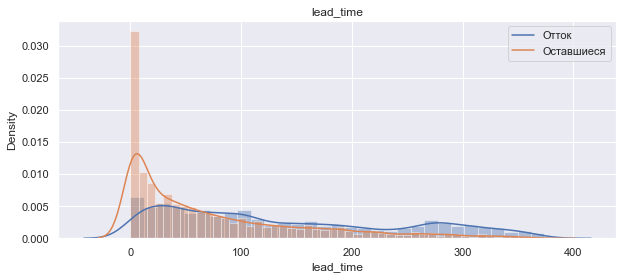

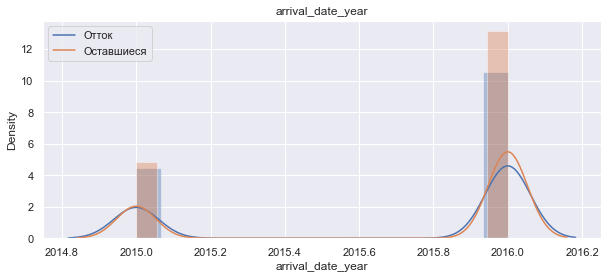

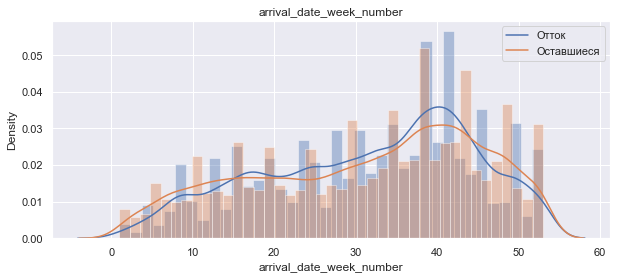

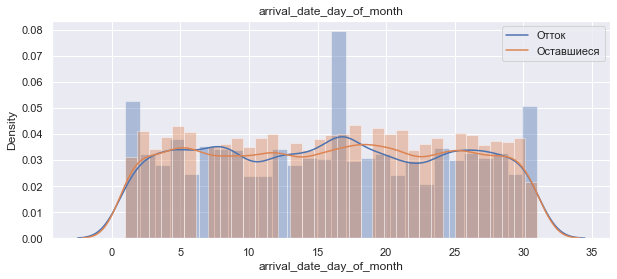

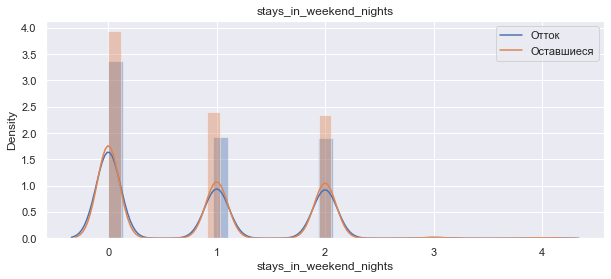

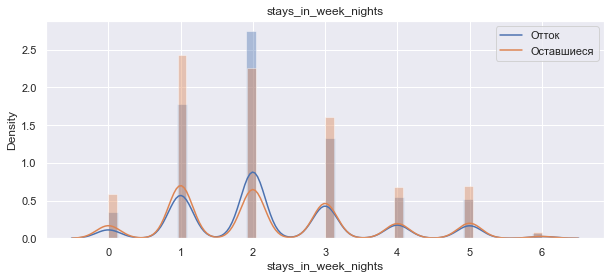

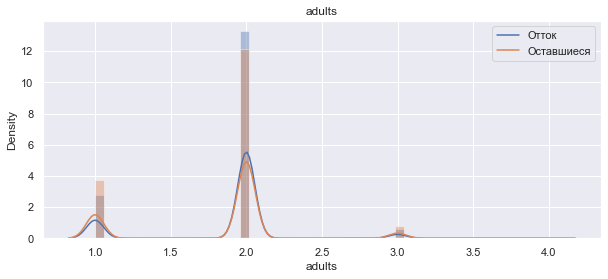

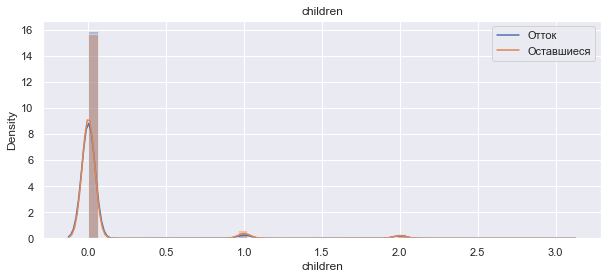

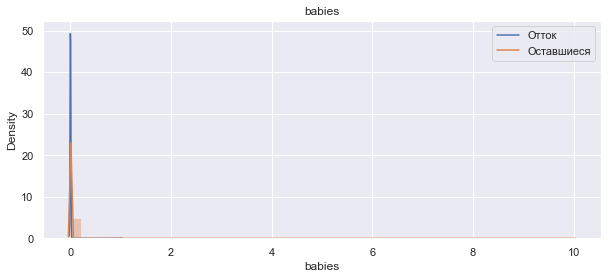

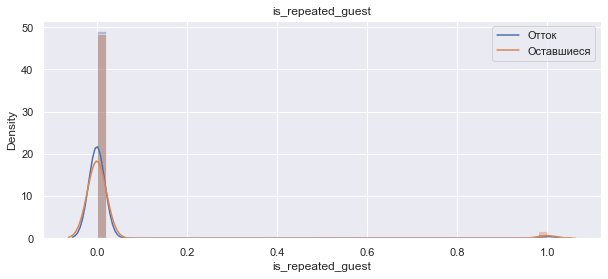

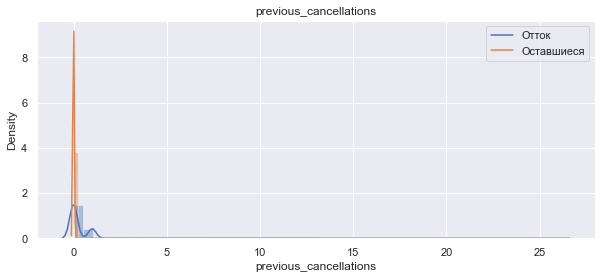

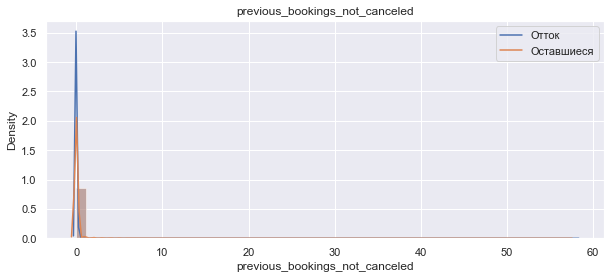

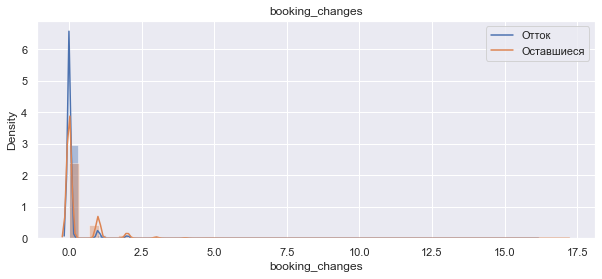

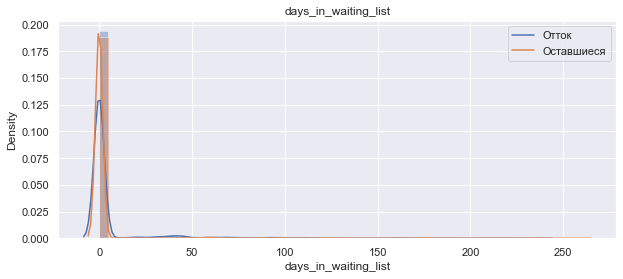

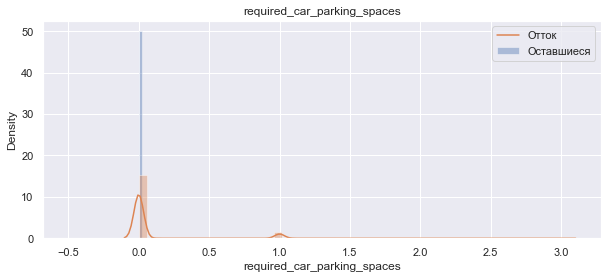

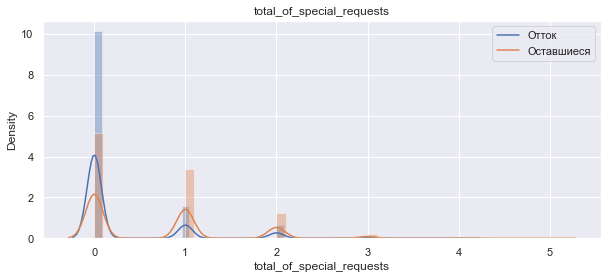

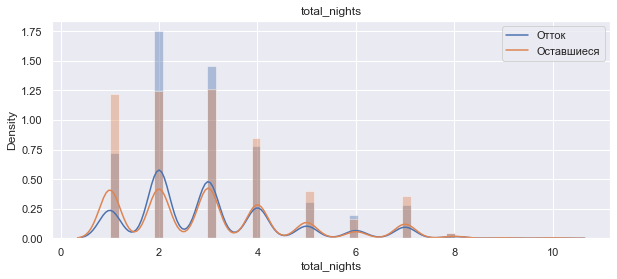

In [27]:
canceled = data_train[data_train['is_canceled']==1]
stayed = data_train[data_train['is_canceled']==0]
distplot_columns = numeric
for column in distplot_columns:
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(canceled[column])
    sns.distplot(stayed[column])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

Построим матрицу корреляции признаков.

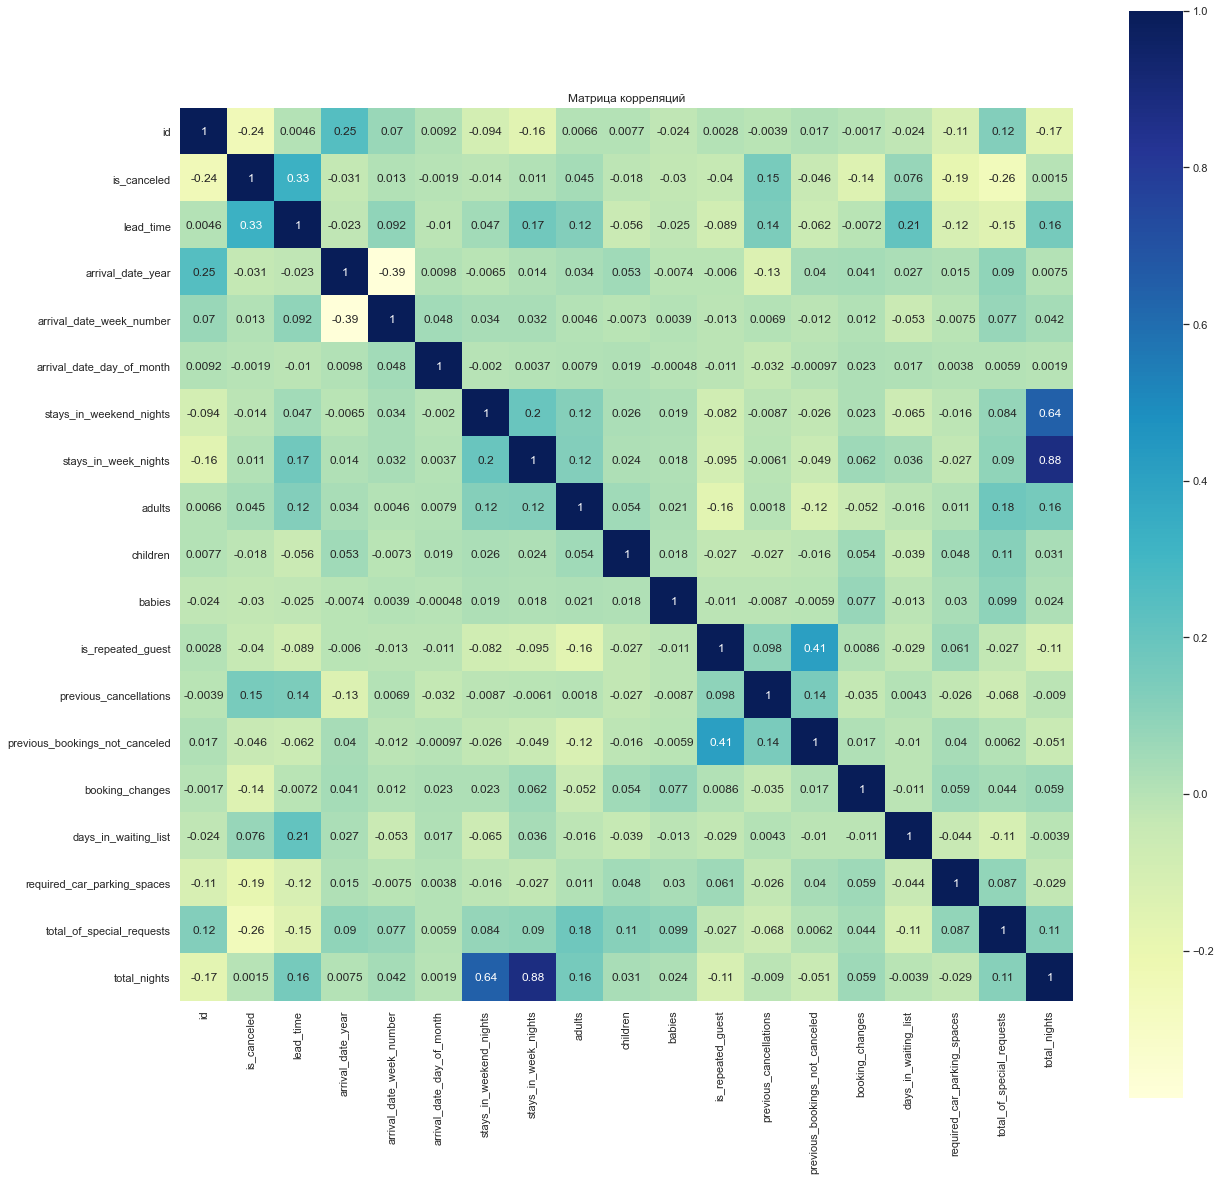

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(data = data_train.corr(), annot=True, square=True, cmap='YlGnBu')
plt.title('Матрица корреляций')
plt.show()

Явной зависимости факта оттока от признаков не обнаружено.
Имеются два мультиколлинеарных признака - stays_in_week_nights и total_nights.

Cудя по описанию, total_nights — это сумма stays_in_week_nights и stays_in_weekend_nights, проверим так ли это.

In [29]:
l = set(list(data_train[['stays_in_week_nights','stays_in_weekend_nights']].sum(axis=1)))
ll = set(list(data_train['total_nights']))
if l == ll: 
    print("Lists are equal") 
else: 
    print("Lists are not equal")


Lists are equal


Удалим лишние столбцы и стоблбец id, он не несет значимости для модели.

In [30]:
data_train = data_train.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 'id'], axis=1)
data_test = data_test.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 'id'], axis=1)
data_train = data_train.drop_duplicates()
data_test = data_test.drop_duplicates()
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())

0
0


### Вывод по шагу 3.

Данные готовы к решению задачи. Были удалены лишние столбцы, заменены типы данных, удалены пробелы в столбцах.

Был произведен исследовательский анализ данных, отмечены общие особенности по всей выборке, произведено сравнение средних значений признаков в двух группах - тех, кто отменил бронирование и тех, кто заселился, проверена корреляция признаков.
В данных имеются выбросы, но они не сильно влияют на среднее значение по выборке.

## Формулировка ML-задачи на основе бизнес-задачи <a id="3"></a>

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

Создадим функцию, присваивающую указанные цены по типу номера и функцию подсчета прибыли.

In [31]:
def prices(df):
    df['room_cost'] = df['reserved_room_type'].map({'A':1000,'B':800, 'C':600,'D':550,'E':500,'F':450,'G':350})
    df['cleaning_cost'] = df['reserved_room_type'].map({'A':400,'B':350, 'C':350,'D':150,'E':150,'F':150,'G':150})
    return df

In [32]:
def profit(row, deposite):
    
    room_cost = row['room_cost']
    cleaning_cost = row['cleaning_cost']
    winter = ['December', 'January', 'February']
    summer = ['June', 'July', 'August']
    
    n = row['total_nights']
    
    
    if row['is_canceled'] == 0:
        expenses = cleaning_cost*(1 + n // 2)
        
        if row['arrival_date_month'] in winter:
            revenue = room_cost*n 
                
        elif row['arrival_date_month'] in summer:   
            revenue = room_cost*n + room_cost*n*0.4
        
        else: 
            revenue = room_cost*n + room_cost*n*0.2
                
    else:
        
        if row['arrival_date_month'] in winter:
            expenses = cleaning_cost + room_cost
                
        elif row['arrival_date_month'] in summer:   
            expenses = cleaning_cost + room_cost + room_cost*0.4
        
        else: 
            expenses = cleaning_cost + room_cost + room_cost*0.2
        
        if deposite == 'on' and row['predictions'] == 1:
            revenue = expenses*0.8
        else:
            revenue = 0

    return revenue - expenses
    
    

In [33]:
df = data_test.copy()
df['profit'] = prices(df).apply(profit, deposite='off', axis=1)
print('Общая прибыль гостиницы без внедрения депозитов за 2017 год:', df['profit'].sum(), 'рублей.')
print('Из-за отмены бронирования гостиница потеряла за 2017 год:', abs(df.query('is_canceled == 1')['profit'].sum()), 'рублей.')

Общая прибыль гостиницы без внедрения депозитов за 2017 год: 32683030.0 рублей.
Из-за отмены бронирования гостиница потеряла за 2017 год: 10571770.0 рублей.


### Вывод по шагу 4.

За 2017 год прибыль составляет 32 млн. рублей, 10 миллионов гостиница потеряла из-за отмен.

## Разработка модели ML <a id="4"></a>

### Подготовка данных.

In [34]:
target_train = data_train['is_canceled']
features_train = data_train.drop('is_canceled', axis=1)
target_test = data_test['is_canceled']
features_test = data_test.drop('is_canceled', axis=1)

In [35]:
numeric = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month',  'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']
cat = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']

In [36]:
encoder = OrdinalEncoder() 
scaler = StandardScaler() 
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

tree_features_train = encoder.fit_transform(features_train, target_train)
tree_features_test = encoder.fit_transform(features_test, target_test)

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
lg_features_train = ohe.fit_transform(features_train, target_train)
lg_features_test = ohe.transform(features_test)



print(tree_features_train.shape, tree_features_test.shape)
print(target_train.shape, target_test.shape)

print(lg_features_train.shape, lg_features_test.shape)
print(target_train.shape, target_test.shape)

(43852, 21) (24695, 21)
(43852,) (24695,)
(43852, 862) (24695, 862)
(43852,) (24695,)


In [37]:
target_train.value_counts()

0    32704
1    11148
Name: is_canceled, dtype: int64

Попробуем обучить три модели - дерево решений, случайный лес, логистическую регрессию без и с исправлением дисбаланса.

Для получения максимальной прибыли нам необходимо минимизировать количество ложноотрицательных ответов модели, поэтому подбирать лучшую по качеству будем по метрике recall. Чем меньше ложноотрицательных срабатываний, тем выше recall модели.

### Дерево решений.

Настроим гиперпараметры.

In [38]:

best_depth = 0
best_recall = 0

for depth in range(1,101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(tree_features_train, target_train)
    predicted = model.predict(tree_features_test)
    recall = recall_score(target_test, predicted)
    if recall > best_recall:
        best_depth = depth
        best_recall = recall

print('Лучшая глубина дерева:', best_depth)
print('Лучшее значение recall:', best_recall)  


Лучшая глубина дерева: 5
Лучшее значение recall: 0.03827874116891458


In [39]:

best_ss = 0
best_recall = 0

for ss in range(2,101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=5, min_samples_split=ss)
    model.fit(tree_features_train, target_train)
    predicted = model.predict(tree_features_test)
    recall = recall_score(target_test, predicted)
    if recall > best_recall:
        best_ss = ss
        best_recall = recall

print('Лучшee значение параметра min_samples_split:', best_ss)
print('Лучшее значение recall:', best_recall) 


Лучшee значение параметра min_samples_split: 2
Лучшее значение recall: 0.03827874116891458


In [40]:

best_ll = 0
best_recall = 0

for ll in range(1,101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=5, min_samples_split=2,min_samples_leaf=ll)
    model.fit(tree_features_train, target_train)
    predicted = model.predict(tree_features_test)
    recall = recall_score(target_test, predicted)
    if recall > best_recall:
        best_ll = ll
        best_recall = recall

print('Лучшee значение параметра min_samples_leaf:', best_ll)
print('Лучшее значение recall:', best_recall) 


Лучшee значение параметра min_samples_leaf: 1
Лучшее значение recall: 0.03827874116891458


In [41]:

tree_model = DecisionTreeClassifier(random_state=12345, max_depth=5, min_samples_split=2,min_samples_leaf=1)
tree_model.fit(tree_features_train, target_train)
predicted = tree_model.predict(tree_features_test)
scores = cross_val_score(tree_model, tree_features_test, target_test, cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score


0.22928709055876687

In [42]:
tree_model1 = DecisionTreeClassifier(random_state=12345, max_depth=5, min_samples_split=2,min_samples_leaf=1, class_weight='balanced')
tree_model1.fit(tree_features_train, target_train)
predicted = tree_model1.predict(tree_features_test)
scores = cross_val_score(tree_model1, tree_features_test, target_test, cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score

0.6633269107257547

### Случайный лес.

In [43]:

best_estim = 0
best_recall = 0

for estim in range(1,101):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim)
    model.fit(tree_features_train, target_train)
    predicted = model.predict(tree_features_test)
    recall = recall_score(target_test, predicted)
    
    if recall > best_recall:
        best_estim = estim
        best_recall = recall

print('Лучшее количество деревьев:', best_estim)
print('Лучшее значение recall:', best_recall)  


Лучшее количество деревьев: 1
Лучшее значение recall: 0.07655748233782916


In [44]:

ff = ['sqrt', 'log2', 'auto']

for f in ff:
    model = RandomForestClassifier(random_state=12345, n_estimators=1, max_features=f)
    model.fit(tree_features_train, target_train)
    predicted = model.predict(tree_features_test)
    recall = recall_score(target_test, predicted)
    
    print(f)
    print(recall)  


sqrt
0.07655748233782916
log2
0.07655748233782916
auto
0.07655748233782916


In [45]:

cc = ['gini', 'entropy']
for c in cc:
    model = RandomForestClassifier(random_state=12345, n_estimators=1, criterion=c)
    model.fit(tree_features_train, target_train)
    predicted = model.predict(tree_features_test)
    recall = recall_score(target_test, predicted)
    
    print(c)
    print(recall) 


gini
0.07655748233782916
entropy
0.0892742453436095


In [46]:

forest_model = RandomForestClassifier(random_state=12345,n_estimators=1, criterion='entropy')
forest_model.fit(tree_features_train, target_train)  
predicted = forest_model.predict(tree_features_test)
scores = cross_val_score(forest_model, tree_features_test, target_test,  cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score


0.38522800256904305

In [47]:

forest_model1 = RandomForestClassifier(random_state=12345,n_estimators=1, criterion='entropy', class_weight='balanced')
forest_model1.fit(tree_features_train, target_train)  
predicted = forest_model1.predict(tree_features_test)
scores = cross_val_score(forest_model1, tree_features_test, target_test,  cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score


0.4008991650610148

### Логистическая регрессия

In [48]:

pp = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
for p in pp:
    model = LogisticRegression(random_state=12345, solver=p)
    model.fit(lg_features_train, target_train)
    predicted = model.predict(lg_features_test)
    recall = recall_score(target_test, predicted)
    
    print(p)
    print(recall)  
    


lbfgs
0.35863840719332046
liblinear
0.38098908156711625
newton-cg
0.20192678227360308
sag
0.20655105973025048
saga
0.23596660244059087


lbfgs
0.35863840719332046
liblinear
0.38098908156711625
newton-cg
0.20192678227360308
sag
0.20655105973025048
saga
0.23596660244059087

In [49]:

max_iter = 0
best_recall = 0

for i in range(1,101):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=i)
    model.fit(lg_features_train, target_train)
    predicted = model.predict(lg_features_test)
    recall = recall_score(target_test, predicted)
    
    if recall > best_recall:
        best_iter = i
        best_recall = recall

print('best_iter:', best_iter)
print('Лучшее значение recall:', best_recall)  


best_iter: 10
Лучшее значение recall: 0.38098908156711625


best_iter: 10
Лучшее значение recall: 0.38098908156711625

In [50]:

log_model =  LogisticRegression(random_state=12345, solver='liblinear', max_iter=10)
log_model.fit(lg_features_train, target_train)
predicted_valid = log_model.predict(lg_features_test)
scores = cross_val_score(log_model, tree_features_test, target_test,  cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score


0.223121387283237

In [51]:
log_model1 =  LogisticRegression(random_state=12345, solver='liblinear', max_iter=10, class_weight='balanced')
log_model1.fit(lg_features_train, target_train)
predicted_test = log_model1.predict(lg_features_test)
scores = cross_val_score(log_model1, tree_features_test, target_test,  cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score

0.6273603082851638

Лучшая средняя оценка качества 0.6633269107257547 у дерева решений с балансом классов.

### Проверка на тестовой выборке.

In [52]:
predicted = tree_model1.predict(tree_features_test)

In [53]:
print('Accuracy:', accuracy_score(target_test, predicted))
print('Precision:', precision_score(target_test, predicted))
print('Recall:', recall_score(target_test, predicted))
print('F1:', f1_score(target_test, predicted))

Accuracy: 0.6719173921846527
Precision: 0.34536585365853656
Recall: 0.045472061657032756
F1: 0.08036322360953461


In [54]:
predicted_lg = log_model1.predict(lg_features_test)

In [55]:
print('Accuracy:', accuracy_score(target_test, predicted_lg))
print('Precision:', precision_score(target_test, predicted_lg))
print('Recall:', recall_score(target_test, predicted_lg))
print('F1:', f1_score(target_test, predicted_lg))

Accuracy: 0.6974286292771816
Precision: 0.5149546106067845
Recall: 0.692228644829801
F1: 0.5905753424657535


Целевая метрика recall, но сравнение по другим метрикам делает логистическую регрессию более презентабельной. Проверим roc-auc и применим функцию расчета прибыли к данным, полученным из обеих моделей.

AUC-ROC DecisionTreeClassifier 0.4669725970009347
AUC-ROC LogisticRegression 0.771173760970372


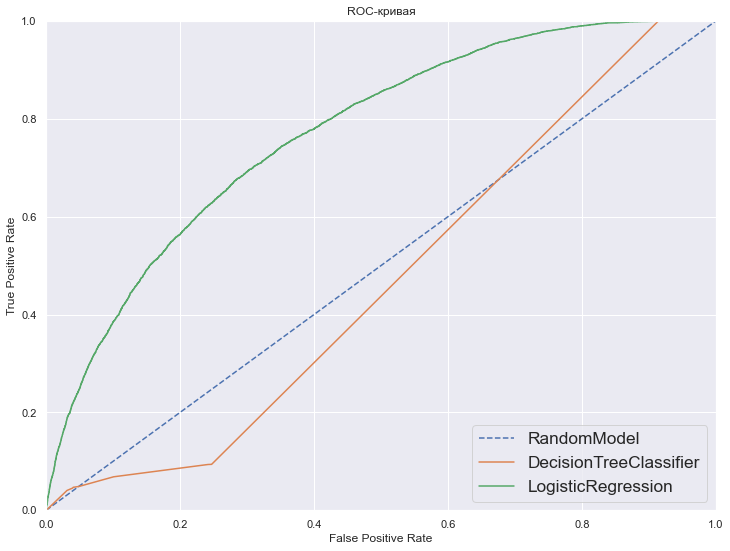

In [56]:

plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')



probabilities_test = tree_model1.predict_proba(tree_features_test)
probabilities_one_valid = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')



probabilities_test_lg = log_model1.predict_proba(lg_features_test)
probabilities_one_valid = probabilities_test_lg[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()


Получили неплохое значение метрики roc-auc у логистической регрессии.

Ранее мы получили следующие данные:

Общая прибыль гостиницы без внедрения депозитов за 2017 год: 32 683030 рублей.

Из-за отмены бронирования гостиница потеряла за 2017 год: 10 571770 рублей.

In [57]:
new_data = data_test.copy()
new_data['predictions'] = predicted

In [58]:

new_data['profit'] = prices(new_data).apply(profit, deposite='on', axis=1)

print('Общая прибыль гостиницы с внедрением депозитов за 2017 год:', new_data['profit'].sum(), 'рублей.')
print('Потери гостиницы с учетом ошибок модели составят:', abs(new_data.query('is_canceled == 1')['profit'].sum()), 'рублей.')
print('Модель дерева решений поможет сохранить:', abs(df.query('is_canceled == 1')['profit'].sum()) - abs(new_data.query('is_canceled == 1')['profit'].sum()), 'рублей.')


Общая прибыль гостиницы с внедрением депозитов за 2017 год: 33065182.0 рублей.
Потери гостиницы с учетом ошибок модели составят: 10189618.0 рублей.
Модель дерева решений поможет сохранить: 382152.0 рублей.


In [59]:
new_data_lg = data_test.copy()
new_data_lg['predictions'] = predicted_lg

In [60]:

new_data_lg['profit'] = prices(new_data_lg).apply(profit, deposite='on', axis=1)
print('Общая прибыль гостиницы с внедрением депозитов за 2017 год:', new_data_lg['profit'].sum(), 'рублей.')
print('Потери гостиницы с учетом ошибок модели составят:', abs(new_data_lg.query('is_canceled == 1')['profit'].sum()), 'рублей.')
print('Модель логистической регрессии поможет сохранить:', abs(df.query('is_canceled == 1')['profit'].sum()) - abs(new_data_lg.query('is_canceled == 1')['profit'].sum()), 'рублей.')


Общая прибыль гостиницы с внедрением депозитов за 2017 год: 38572574.0 рублей.
Потери гостиницы с учетом ошибок модели составят: 4682226.0 рублей.
Модель логистической регрессии поможет сохранить: 5889544.0 рублей.


На разработку системы прогнозирования заложен бюджет — 400 000. Окупается только модель логистической регрессии.

### Вывод по шагу 5.
Было обучено три модели: решающее дерево, случайный лес и логистическая регрессия. После устранения дисбаланса в классах лучший результат по средней оценке качества получили у модели случайного леса - 0.8616.

Модель была применена на тестовой  выборке, значение метрики roc-auc =  0.807.

Функция подсчета прибыли применена на пресказанных результатах. Прибыль бизнеса с внедрением модели увеличится на почти 6 миллионов.

## Портрет «ненадёжного» клиента <a id="5"></a>

In [61]:
data_ohe = pd.get_dummies(data_train, drop_first=True)

In [62]:
target = data_ohe['is_canceled']
features = data_ohe.drop('is_canceled', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, 
                                                                              random_state=12345, stratify=target)


scaler = StandardScaler(with_mean=False)
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])



print(features_train.shape, features_valid.shape)
print(target_train.shape, target_valid.shape)


(32889, 195) (10963, 195)
(32889,) (10963,)


In [63]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

Рассмотрим долю вклада каждого признака в итоговое предстказание.

In [64]:
feat_import = pd.DataFrame(data = {'feature': features_train.columns, 'percent': model.feature_importances_})
feat_import.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,lead_time,1.875564e-01
1,arrival_date_day_of_month,1.112652e-01
2,arrival_date_week_number,8.392168e-02
3,total_nights,7.877994e-02
4,total_of_special_requests,6.033878e-02
5,country_PRT,3.956400e-02
6,previous_cancellations,2.998305e-02
7,adults,2.530303e-02
8,required_car_parking_spaces,2.447568e-02
9,arrival_date_year,2.291086e-02


In [65]:
data_test.query('is_canceled==1').describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,7785.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
lead_time,7785.0,116.997174,90.019121,0.0,39.0,99.0,176.0,373.0
arrival_date_year,7785.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_week_number,7785.0,19.101991,9.253642,1.0,12.0,19.0,27.0,35.0
arrival_date_day_of_month,7785.0,15.421965,8.739028,1.0,8.0,15.0,23.0,31.0
adults,7785.0,1.975723,0.451731,1.0,2.0,2.0,2.0,4.0
children,7785.0,0.136288,0.442245,0.0,0.0,0.0,0.0,3.0
babies,7785.0,0.002954,0.054278,0.0,0.0,0.0,0.0,1.0
is_repeated_guest,7785.0,0.005909,0.076646,0.0,0.0,0.0,0.0,1.0
previous_cancellations,7785.0,0.006423,0.116518,0.0,0.0,0.0,0.0,4.0


In [66]:
data_test.query('is_canceled==1')['total_nights'].value_counts()

3     2034
4     1627
2     1394
1      911
5      714
7      659
6      323
8       87
10      19
9       17
Name: total_nights, dtype: int64

Наиболее важные признаки ненадежного клиента:

- чем больше дней до заезда остается, тем вероятнее отмена бронирования
- гости из Португалии отменяют бронирование чаще остальных
- ненадежным является клиент с большим количеством специальных отметок
- если клиент уже отменял бронирование раньше, вероятнее всего он отменит его и в этот раз
- в среднем ненадежный клиент бронирует номер на 3-4 дня


## Общий вывод <a id="6"></a>

В ходе исследования данные были подготовлены для обучения модели: удалены столбцы, не имеющие значимость, изменены типы данных, заменены значения в столбцах.

Написана функция подсчета прибыли с учетом внедрения депозита и без.

Обучены модели, на основе показателя лучшей средней оценки выбрана модель случайного леса для предсказания отмены бронирования. Метрика roc-auc равна 0.807.

Использование модели в бизнесе может помочь увеличить прибыль гостиницы в два раза. Выделенный на разработку бюджет окупается.

Составлен портрет "ненадежного клиента".